In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # Include this
import torch.optim as optim
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.metrics import pairwise_distances
import pandas as pd

# AdaptiveKDE, Initialiser, Enhancer, AIENs classes (as defined earlier)
class AdaptiveKDE:
    def __init__(self, data, base_bandwidth=1.0, k=10):
        self.data = data
        self.k = k
        self.base_bandwidth = base_bandwidth
        self.kdes = []
        self._fit_adaptive_kde()

    def _fit_adaptive_kde(self):
        distances = pairwise_distances(self.data)
        for i in range(self.data.shape[0]):
            local_bandwidth = self.base_bandwidth * np.mean(np.sort(distances[i])[:self.k])
            kde = KernelDensity(kernel='gaussian', bandwidth=local_bandwidth)
            kde.fit(self.data)
            self.kdes.append(kde)

    def log_prob(self, samples):
        log_probs = np.zeros(samples.shape[0])
        for kde in self.kdes:
            log_probs += kde.score_samples(samples)
        return log_probs / len(self.kdes)

class Initialiser(nn.Module):
    def __init__(self, input_dim):
        super(Initialiser, self).__init__()
        layers = []
        for _ in range(input_dim // 4):
            layers.append(nn.Linear(input_dim, input_dim))
            layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

class Enhancer(nn.Module):
    def __init__(self, input_dim):
        super(Enhancer, self).__init__()
        layers = []
        for _ in range(3 * input_dim // 8):
            layers.append(nn.Linear(input_dim, input_dim))
            layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

class AIENs(nn.Module):
    def __init__(self, input_dim):
        super(AIENs, self).__init__()
        self.initialiser = Initialiser(input_dim)
        self.fc_mu = nn.Linear(input_dim, input_dim)
        self.fc_logvar = nn.Linear(input_dim, input_dim)
        self.enhancer = Enhancer(input_dim)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

    def reparameterize(self, mu, logvar):
        # Clamp logvar to prevent numerical instability
        logvar = torch.clamp(logvar, min=-10, max=10)  # Avoid extreme values
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


    def forward(self, x):
        latent = self.initialiser(x)
        mu, logvar = self.fc_mu(latent), self.fc_logvar(latent)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.enhancer(z)
        return reconstruction, mu, logvar

# Synthetic Data Generation only on enhancer
def generate_synthetic_data(model, no_of_sample, input_dim):
    model.eval()
    with torch.no_grad():
        # Sample latent space
        z = torch.randn(no_of_sample, input_dim)
        # Generate synthetic data
        synthetic_data = model.enhancer(z).numpy()
    return synthetic_data

def generate_synthetic_data_full_aien(model, no_of_sample, input_dim):
    """
    Generate synthetic data using the full AIENs model.

    Parameters:
    - model: Trained AIENs model.
    - no_of_sample: Number of synthetic samples to generate.
    - input_dim: Number of features in the dataset.

    Returns:
    - synthetic_data: NumPy array of generated synthetic data.
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Step 1: Sample latent space from standard Gaussian
        z = torch.randn(no_of_sample, input_dim)
        
        # Step 2: Pass through Initialiser to simulate latent space
        latent = model.initialiser(z)
        
        # Step 3: Compute mu and logvar from Initialiser output
        mu, logvar = model.fc_mu(latent), model.fc_logvar(latent)
        
        # Step 4: Reparameterize latent space
        z_reparameterized = model.reparameterize(mu, logvar)
        
        # Step 5: Pass through Enhancer to generate synthetic data
        synthetic_data = model.enhancer(z_reparameterized).cpu().numpy()
    
    return synthetic_data


# Load CSV data
def load_data(file_path):
    data = pd.read_csv(file_path, header=None)
    numeric_data = data.iloc[:, :-7].values  # Exclude the class label working with 10 dimensions
    return numeric_data

# SEKER, BARBUNYA, BOMBAY, CALI, HOROZ
def save_synthetic_data(synthetic_data, output_file):
    synthetic_df = pd.DataFrame(np.round(synthetic_data, 4), columns=['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity'])
    synthetic_df['Class'] = "SEKER"
    synthetic_df.to_csv(output_file, index=False)
    print(f"Synthetic data saved to {output_file}")

# Main Script
if __name__ == "__main__":
    # Define dataset and train AIENs as before
    input_dim = 10  # Number of columns in dataset
    input_file = "bean1.csv"
    dataset = load_data(input_file)
    adaptive_kde = AdaptiveKDE(dataset)
    model = AIENs(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Dummy dataloader
    dataloader = torch.utils.data.DataLoader(
        torch.from_numpy(dataset).float(), batch_size=32, shuffle=True
    )

    # Training function
    def train_aien(model, dataloader, adaptive_kde, optimizer, num_epochs=500):
        model.train()
        for epoch in range(num_epochs):
            epoch_loss = 0
            for batch in dataloader:
                x = batch.float()
                optimizer.zero_grad()
                recon_x, mu, logvar = model(x)
                z = model.reparameterize(mu, logvar)
                mse_loss = F.mse_loss(recon_x, x, reduction='sum')
                kl_div = torch.sum(torch.tensor(adaptive_kde.log_prob(z.cpu().detach().numpy())))
                loss = mse_loss - kl_div
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.2f}")

    # Train the model
    train_aien(model, dataloader, adaptive_kde, optimizer)

    # Generate synthetic data
    no_of_sample = 500  # Number of synthetic samples to generate
    synthetic_data = generate_synthetic_data_full_aien(model, no_of_sample, input_dim)
    output_file = "synthetic_data_1.csv"
    # Save synthetic data to CSV
    save_synthetic_data(synthetic_data, output_file)
    print(f"Synthetic data saved to 'synthetic_data.csv'")
    model.info()


Model Summary:
Epoch 1, Loss: 99620489488.90
Epoch 2, Loss: 99620346421.29
Epoch 3, Loss: 99620189670.29
Epoch 4, Loss: 99620026459.04
Epoch 5, Loss: 99619844801.35
Epoch 6, Loss: 99619641283.50
Epoch 7, Loss: 99619420577.83
Epoch 8, Loss: 99619186924.32
Epoch 9, Loss: 99618936393.92
Epoch 10, Loss: 99618686219.89
Epoch 11, Loss: 99618448375.34
Epoch 12, Loss: 99618236213.07
Epoch 13, Loss: 99618049125.15
Epoch 14, Loss: 99617948016.94
Epoch 15, Loss: 99617863755.61
Epoch 16, Loss: 99617678840.56
Epoch 17, Loss: 99598197463.76
Epoch 18, Loss: 99555070378.83
Epoch 19, Loss: 99499638095.64
Epoch 20, Loss: 99431102137.35
Epoch 21, Loss: 99346961320.28
Epoch 22, Loss: 99249211244.11
Epoch 23, Loss: 99135869987.20
Epoch 24, Loss: 99008855435.65
Epoch 25, Loss: 98876740631.77
Epoch 26, Loss: 98727745319.68
Epoch 27, Loss: 98549398450.45
Epoch 28, Loss: 98351132804.44
Epoch 29, Loss: 98117284975.62
Epoch 30, Loss: 97850296809.16
Epoch 31, Loss: 97543049420.70
Epoch 32, Loss: 97199360641.55
Ep

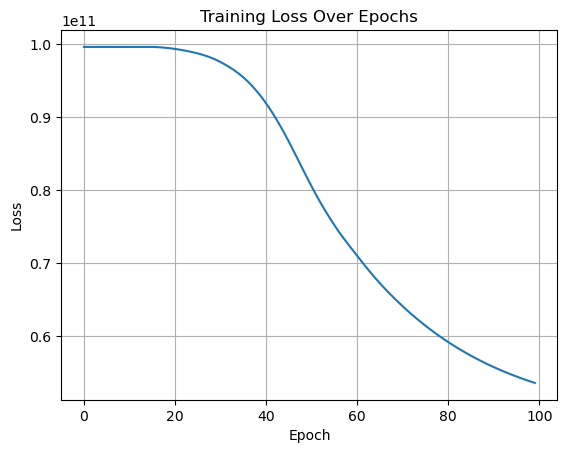

Synthetic data saved to synthetic_data.csv


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.neighbors import KernelDensity
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

# ==============================
# AdaptiveKDE Class
# ==============================
class AdaptiveKDE:
    def __init__(self, data, base_bandwidth=1.0, k=10):
        self.data = data
        self.k = k
        self.base_bandwidth = base_bandwidth
        self.kdes = []
        self._fit_adaptive_kde()

    def _fit_adaptive_kde(self):
        distances = pairwise_distances(self.data)
        for i in range(self.data.shape[0]):
            local_bandwidth = self.base_bandwidth * np.mean(np.sort(distances[i])[:self.k])
            kde = KernelDensity(kernel='gaussian', bandwidth=local_bandwidth)
            kde.fit(self.data)
            self.kdes.append(kde)

    def log_prob(self, samples):
        log_probs = np.zeros(samples.shape[0])
        for kde in self.kdes:
            log_probs += kde.score_samples(samples)
        return log_probs / len(self.kdes)

# ==============================
# Initialiser and Enhancer
# ==============================
class Initialiser(nn.Module):
    def __init__(self, input_dim):
        super(Initialiser, self).__init__()
        layers = [nn.Linear(input_dim, input_dim), nn.ReLU()] * (input_dim // 4)
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

class Enhancer(nn.Module):
    def __init__(self, input_dim):
        super(Enhancer, self).__init__()
        layers = [nn.Linear(input_dim, input_dim), nn.ReLU()] * (3 * input_dim // 8)
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

# ==============================
# AIENs Model
# ==============================
class AIENs(nn.Module):
    def __init__(self, input_dim):
        super(AIENs, self).__init__()
        self.initialiser = Initialiser(input_dim)
        self.fc_mu = nn.Linear(input_dim, input_dim)
        self.fc_logvar = nn.Linear(input_dim, input_dim)
        self.enhancer = Enhancer(input_dim)

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        latent = self.initialiser(x)
        mu, logvar = self.fc_mu(latent), self.fc_logvar(latent)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.enhancer(z)
        return reconstruction, mu, logvar

# ==============================
# Data Loading and Saving
# ==============================
def load_data(file_path):
    data = pd.read_csv(file_path, header=None)
    numeric_data = data.iloc[:, :-6].values  # Assume 10 dimensions are used
    return numeric_data

# def save_synthetic_data(synthetic_data, output_file):
#     columns = ['Feature_' + str(i+1) for i in range(synthetic_data.shape[1])] + ['Class']
#     synthetic_df = pd.DataFrame(np.round(synthetic_data, 4), columns=columns)
#     synthetic_df['Class'] = "SEKER"
#     synthetic_df.to_csv(output_file, index=False)
#     print(f"Synthetic data saved to {output_file}")
def save_synthetic_data(synthetic_data, output_file):
    columns = ['Feature_' + str(i+1) for i in range(synthetic_data.shape[1])]
    synthetic_df = pd.DataFrame(np.round(synthetic_data, 4), columns=columns)
    synthetic_df['Class'] = "SEKER"  # Add the 'Class' column after DataFrame creation
    synthetic_df.to_csv(output_file, index=False)
    print(f"Synthetic data saved to {output_file}")
# ==============================
# Training Function
# ==============================
def train_aien(model, dataloader, adaptive_kde, optimizer, num_epochs=50):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in dataloader:
            x = batch.float()
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            z = model.reparameterize(mu, logvar)
            mse_loss = F.mse_loss(recon_x, x, reduction='sum')
            kl_div = torch.sum(torch.tensor(adaptive_kde.log_prob(z.cpu().detach().numpy())))
            loss = mse_loss - kl_div
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.2f}")
    return epoch_losses

# ==============================
# Visualization
# ==============================
def plot_loss(epoch_losses):
    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    
# Synthetic Data Generation only on enhancer
def generate_synthetic_data(model, no_of_sample, input_dim):
    model.eval()
    with torch.no_grad():
        # Sample latent space
        z = torch.randn(no_of_sample, input_dim)
        # Generate synthetic data
        synthetic_data = model.enhancer(z).numpy()
    return synthetic_data

def generate_synthetic_data_full_aien(model, no_of_sample, input_dim):
    """
    Generate synthetic data using the full AIENs model.

    Parameters:
    - model: Trained AIENs model.
    - no_of_sample: Number of synthetic samples to generate.
    - input_dim: Number of features in the dataset.

    Returns:
    - synthetic_data: NumPy array of generated synthetic data.
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Step 1: Sample latent space from standard Gaussian
        z = torch.randn(no_of_sample, input_dim)
        
        # Step 2: Pass through Initialiser to simulate latent space
        latent = model.initialiser(z)
        
        # Step 3: Compute mu and logvar from Initialiser output
        mu, logvar = model.fc_mu(latent), model.fc_logvar(latent)
        
        # Step 4: Reparameterize latent space
        z_reparameterized = model.reparameterize(mu, logvar)
        
        # Step 5: Pass through Enhancer to generate synthetic data
        synthetic_data = model.enhancer(z_reparameterized).cpu().numpy()
    
    return synthetic_data

# ==============================
# Main Script
# ==============================
if __name__ == "__main__":
    # Load dataset
    input_file = "bean1.csv"
    dataset = load_data(input_file)
    adaptive_kde = AdaptiveKDE(dataset)
    input_dim = 11

    model = AIENs(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    dataloader = torch.utils.data.DataLoader(
        torch.from_numpy(dataset).float(), batch_size=32, shuffle=True
    )

    print("Model Summary:")
    summary(model, input_size=(32, input_dim))

    # Train model
    epoch_losses = train_aien(model, dataloader, adaptive_kde, optimizer, num_epochs=100)

    # Plot Losses
    plot_loss(epoch_losses)

    # Generate and Save Synthetic Data
    synthetic_data = generate_synthetic_data_full_aien(model, 500, input_dim)
    save_synthetic_data(synthetic_data, "synthetic_data.csv")

    

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.neighbors import KernelDensity
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

# ==============================
# AdaptiveKDE Class
# ==============================
class AdaptiveKDE:
    def __init__(self, data, base_bandwidth=1.0, k=10):
        self.data = data
        self.k = k
        self.base_bandwidth = base_bandwidth
        self.kdes = []
        self._fit_adaptive_kde()

    def _fit_adaptive_kde(self):
        distances = pairwise_distances(self.data)
        for i in range(self.data.shape[0]):
            local_bandwidth = self.base_bandwidth * np.mean(np.sort(distances[i])[:self.k])
            kde = KernelDensity(kernel='gaussian', bandwidth=local_bandwidth)
            kde.fit(self.data)
            self.kdes.append(kde)

    def log_prob(self, samples):
        log_probs = np.zeros(samples.shape[0])
        for kde in self.kdes:
            log_probs += kde.score_samples(samples)
        return log_probs / len(self.kdes)

# ==============================
# Initialiser and Enhancer
# ==============================
class Initialiser(nn.Module):
    def __init__(self, input_dim):
        super(Initialiser, self).__init__()
        layers = [nn.Linear(input_dim, input_dim), nn.ReLU()] * (4 * input_dim)
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

class Enhancer(nn.Module):
    def __init__(self, input_dim):
        super(Enhancer, self).__init__()
        layers = [nn.Linear(input_dim, input_dim), nn.ReLU()] * (8 * input_dim)
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

# ==============================
# AIENs Model
# ==============================
class AIENs(nn.Module):
    def __init__(self, input_dim):
        super(AIENs, self).__init__()
        self.initialiser = Initialiser(input_dim)
        self.fc_mu = nn.Linear(input_dim, input_dim)
        self.fc_logvar = nn.Linear(input_dim, input_dim)
        self.enhancer = Enhancer(input_dim)

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        latent = self.initialiser(x)
        mu, logvar = self.fc_mu(latent), self.fc_logvar(latent)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.enhancer(z)
        return reconstruction, mu, logvar

# ==============================
# Data Loading and Saving
# ==============================
def load_data(file_path):
    data = pd.read_csv(file_path, header=None)
    numeric_data = data.iloc[:, :-6].values  # Assume 10 dimensions
    return numeric_data

def save_synthetic_data(synthetic_data, output_file):
    columns = ['Feature_' + str(i+1) for i in range(synthetic_data.shape[1])]
    synthetic_df = pd.DataFrame(np.round(synthetic_data, 4), columns=columns)
    synthetic_df['Class'] = "SEKER"
    synthetic_df.to_csv(output_file, index=False)
    print(f"Synthetic data saved to {output_file}")

# ==============================
# Training Function
# ==============================
def train_aien(model, dataloader, adaptive_kde, optimizer, num_epochs=50, beta=1.0):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in dataloader:
            x = batch.float()
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            z = model.reparameterize(mu, logvar)
            mse_loss = F.mse_loss(recon_x, x, reduction='sum')
            kl_div = torch.sum(torch.tensor(adaptive_kde.log_prob(z.cpu().detach().numpy())))
            loss = mse_loss + beta * kl_div
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.2f}")
    return epoch_losses

# ==============================
# Visualization
# ==============================
def plot_loss(epoch_losses):
    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

In [16]:
import torch
import torch.nn.functional as F

def train_aien_and_save_best_model(model, dataloader, adaptive_kde, optimizer, num_epochs=50, beta=1.0, save_path="best_model.pth"):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    model.train()
    epoch_losses = []
    best_loss = float('inf')  # Initialize with infinity

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in dataloader:
            x = batch.float()
            optimizer.zero_grad()
            
            # Forward pass
            recon_x, mu, logvar = model(x)
            z = model.reparameterize(mu, logvar)
            
            # Compute losses
            mse_loss = F.mse_loss(recon_x, x, reduction='sum')
            kl_div = torch.sum(torch.tensor(adaptive_kde.log_prob(z.cpu().detach().numpy())))
            loss = mse_loss + beta * kl_div
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Learning rate scheduler step
        scheduler.step()
        
        # Log loss for the current epoch
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.2f}")

        # Save the model if this is the best loss so far
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved with loss: {best_loss:.2f}")

    return epoch_losses


Model Summary:
Epoch 1/100, Loss: 99615261487.86
New best model saved with loss: 99615261487.86
Epoch 2/100, Loss: 99615245120.08
New best model saved with loss: 99615245120.08
Epoch 3/100, Loss: 99615224601.80
New best model saved with loss: 99615224601.80
Epoch 4/100, Loss: 99615199986.71
New best model saved with loss: 99615199986.71
Epoch 5/100, Loss: 99615187764.58
New best model saved with loss: 99615187764.58
Epoch 6/100, Loss: 99615171338.47
New best model saved with loss: 99615171338.47
Epoch 7/100, Loss: 99615146771.50
New best model saved with loss: 99615146771.50
Epoch 8/100, Loss: 99615126342.77
New best model saved with loss: 99615126342.77
Epoch 9/100, Loss: 99615118099.67
New best model saved with loss: 99615118099.67
Epoch 10/100, Loss: 99615093563.59
New best model saved with loss: 99615093563.59
Epoch 11/100, Loss: 99615073039.13
New best model saved with loss: 99615073039.13
Epoch 12/100, Loss: 99615052535.95
New best model saved with loss: 99615052535.95
Epoch 13/1

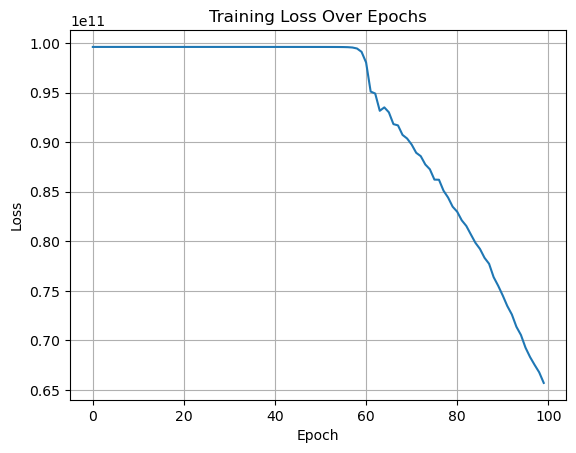

Synthetic data saved to synthetic_data_1.csv


In [17]:
if __name__ == "__main__":
    input_file = "bean1.csv"
    dataset = load_data(input_file)
    adaptive_kde = AdaptiveKDE(dataset)
    
    input_dim = 11
    model = AIENs(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    dataloader = torch.utils.data.DataLoader(
        torch.from_numpy(dataset).float(), batch_size=32, shuffle=True
    )

    print("Model Summary:")
    summary(model, input_size=(32, input_dim))

    # Train and save the best model
    epoch_losses = train_aien_and_save_best_model(model, dataloader, adaptive_kde, optimizer, num_epochs=100, save_path="best_model.pth")

    # Plot training loss
    plot_loss(epoch_losses)

    # Load the best model for generating synthetic data
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    # Generate and Save Synthetic Data
    synthetic_data = generate_synthetic_data_full_aien(model, 500, input_dim)
    save_synthetic_data(synthetic_data, "synthetic_data_1.csv")
